In [1]:
import numpy as np
import pandas as pd
import datetime
import torch
import transformers
import matplotlib.pyplot as plt
import sklearn.model_selection
import sklearn.metrics
import TweetNormalizer

In [2]:
device = torch.device('cuda:0')

In [3]:
train = pd.read_csv('data/train.csv')[['keyword', 'location', 'text', 'target']].fillna('')
train.text = train.text.map(TweetNormalizer.normalizeTweet)
train.head()

,keyword,location,text,target
0,,,Our Deeds are the Reason of this #earthquake M...,1
1,,,Forest fire near La Ronge Sask . Canada,1
2,,,All residents asked to ' shelter in place ' ar...,1
3,,,"13,000 people receive #wildfires evacuation or...",1
4,,,Just got sent this photo from Ruby #Alaska as ...,1


In [4]:
model_name = 'vinai/bertweet-base'
tokenizer = transformers.AutoTokenizer.from_pretrained(model_name)

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [5]:
transformer_learning_rate = 0.000005
classifier_learning_rate = 0.00001
batch_size = 16
dropout = 0.5
hidden_size = 200
max_epochs = 10

In [6]:
keywords = tokenizer(train.keyword.tolist(), padding = True, return_tensors = 'pt')
locations = tokenizer(train.location.tolist(), padding = True, return_tensors = 'pt')
texts = tokenizer(train.text.tolist(), padding = True, return_tensors = 'pt')

targets = torch.tensor(train.target.tolist()).to(torch.float)

In [7]:
train_ids, test_ids = sklearn.model_selection.train_test_split(range(len(targets)))
train_ids, val_ids  = sklearn.model_selection.train_test_split(train_ids)

class Dataset(torch.utils.data.Dataset): 
    def __init__(self, keywords, locations, texts, targets, ids):
        self.keywords  = keywords
        self.locations = locations
        self.texts     = texts
        self.targets   = targets
        self.ids       = ids
        
    def __getitem__(self, index):        
        return {
            'keyword_ids':         self.keywords['input_ids'][self.ids[index]],
            'keyword_attentions':  self.keywords['attention_mask'][self.ids[index]],
            'location_ids':        self.locations['input_ids'][self.ids[index]],
            'location_attentions': self.locations['attention_mask'][self.ids[index]],
            'text_ids':            self.texts['input_ids'][self.ids[index]],
            'text_attentions':     self.texts['attention_mask'][self.ids[index]]
        }, self.targets[self.ids[index]]

    
    def __len__(self):
        return len(self.ids)

train_dataloader = torch.utils.data.DataLoader(
    Dataset(keywords, locations, texts, targets, train_ids),
    batch_size = batch_size,
    shuffle = True
)

val_dataloader = torch.utils.data.DataLoader(
    Dataset(keywords, locations, texts, targets, val_ids),
    batch_size = batch_size
)

test_dataloader = torch.utils.data.DataLoader(
    Dataset(keywords, locations, texts, targets, test_ids),
    batch_size = batch_size
)

In [8]:
class Transformer3(torch.nn.Module):
    def __init__(self, model_name, dropout, hidden_size):
        super().__init__()
        self.transformer_model = transformers.AutoModelForMaskedLM.from_pretrained(model_name)
        self.dropout1 = torch.nn.Dropout(dropout)
        
        linear_in_size = self.transformer_model.config.hidden_size * (
            keywords['input_ids'].shape[1] + 
            locations['input_ids'].shape[1] + 
            texts['input_ids'].shape[1]
        )
        
        self.hidden_layer = torch.nn.Linear(linear_in_size, hidden_size)
        self.dropout2 = torch.nn.Dropout(dropout)
        self.out_layer = torch.nn.Linear(hidden_size, 1)
        
    def forward(self, X):
        keyword_out = self.transformer_model(
            X['keyword_ids'],
            X['keyword_attentions'],
            output_hidden_states = True,
            return_dict = True
        ).hidden_states[-1].flatten(1, 2)

        location_out = self.transformer_model(
            X['location_ids'],
            X['location_attentions'],
            output_hidden_states = True,
            return_dict = True
        ).hidden_states[-1].flatten(1, 2)

        text_out = self.transformer_model(
            X['text_ids'],
            X['text_attentions'],
            output_hidden_states = True,
            return_dict = True
        ).hidden_states[-1].flatten(1, 2)
        
        transformer_out = self.dropout1(torch.concat([keyword_out, location_out, text_out], dim = 1))
        hidden_out = torch.nn.Sigmoid()(self.dropout2(self.hidden_layer(transformer_out)))
        return torch.nn.Sigmoid()(self.out_layer(hidden_out).squeeze())
    
model = Transformer3(model_name, dropout, hidden_size).to(device)

In [9]:
%%time

train_loss = []
val_loss   = []
epoch_checkpoints = []

optimizer = torch.optim.AdamW([
    {'params': model.transformer_model.parameters(), 'lr': transformer_learning_rate},
    {'params': model.hidden_layer.parameters(), 'lr': classifier_learning_rate},
    {'params': model.out_layer.parameters(), 'lr': classifier_learning_rate}
])

for e in range(max_epochs):
    train_loss_epoch = []
    model.train()
    
    for i, (X, y) in enumerate(train_dataloader):

        X = {k: v.to(device) for k, v in X.items()}
        y = y.to(device)
        
        model.zero_grad()
        logits = model(X)
        loss   = torch.nn.BCELoss()(logits, y)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        train_loss_epoch.append(loss.item())
        m = f'Epoch: {e + 1 :2}/{max_epochs}, '
        m += f'Iteration: {i + 1 :3}/{len(train_dataloader)}, '
        m += f'Train Loss: {sum(train_loss_epoch)/len(train_loss_epoch):.04}'
        print('\r', m, end = '')

    train_loss.append(train_loss_epoch)

    val_loss_epoch = []
    model.eval()
    
    for X, y in val_dataloader:
        X = {k: v.to(device) for k, v in X.items()}
        y = y.to(device)

        with torch.no_grad():
            logits = model(X)
            loss = torch.nn.BCELoss()(logits, y)
            
        val_loss_epoch.append(loss.item())
    
    mean_val_loss_epoch = sum(val_loss_epoch)/len(val_loss_epoch)
    val_loss.append(mean_val_loss_epoch)
    print(f', Val Loss: {mean_val_loss_epoch:.04}')
    
    epoch_checkpoints.append(model.state_dict())
    
    early_stop = 3
    if (len(val_loss) >= early_stop) and min(val_loss[-early_stop:]) == val_loss[-early_stop]:
        break
        
num_epochs = e + 1

 Epoch:  1/10, Iteration: 268/268, Train Loss: 0.5209, Val Loss: 0.3862
 Epoch:  2/10, Iteration: 268/268, Train Loss: 0.4018, Val Loss: 0.4417
 Epoch:  3/10, Iteration: 268/268, Train Loss: 0.3727, Val Loss: 0.4262
CPU times: user 4min 4s, sys: 2min 41s, total: 6min 46s
Wall time: 6min 45s


In [10]:
best_epoch = val_loss.index(min(val_loss))
model.load_state_dict(epoch_checkpoints[best_epoch])

<All keys matched successfully>

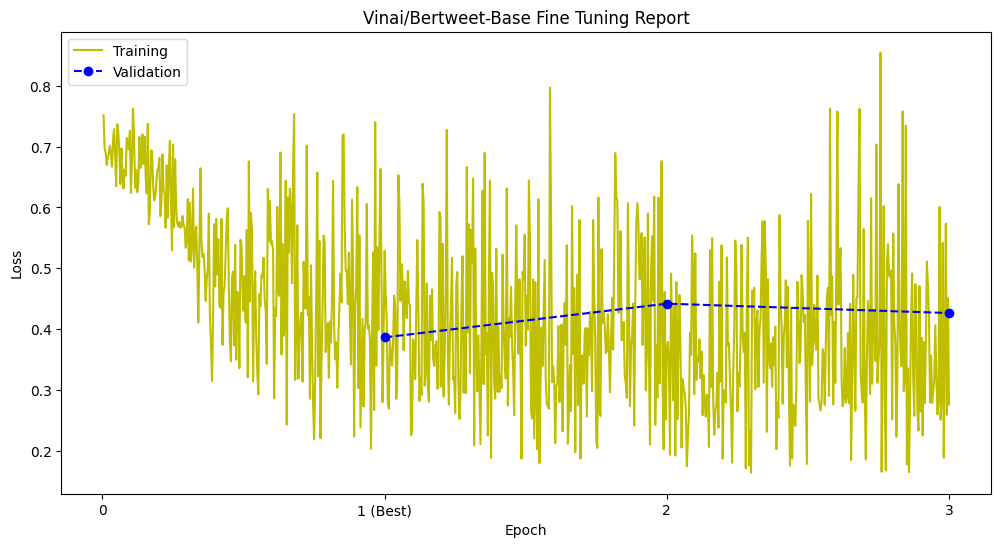

In [11]:
iter_ticks = np.arange(num_epochs * len(train_loss_epoch)) + 1
epoch_ticks = (np.arange(num_epochs) + 1) * len(train_loss_epoch)

plt.figure(figsize = (12, 6))

plt.plot(iter_ticks, [b for a in train_loss for b in a], 'y', label = 'Training')
plt.plot(epoch_ticks, val_loss, '--ob', label = 'Validation')

xlabels = list(map(str, range(num_epochs + 1)))
xlabels[best_epoch + 1] += ' (Best)'

plt.xticks(np.arange(num_epochs + 1) * len(train_loss_epoch), xlabels)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title(f'{model_name.title()} Fine Tuning Report')
plt.legend()

training_record = plt.gcf()

In [12]:
pred_probs = []
true = []

for (X, y) in test_dataloader:
    X = {k: v.to(device) for k, v in X.items()}
    pred_probs.extend(model(X).detach().cpu().numpy())
    true.extend(y.numpy())

pred_probs = np.array(pred_probs)
pred_probs
pred = pred_probs > 0.5
true = np.array(true)

In [13]:
classification_report = sklearn.metrics.classification_report(true, pred, zero_division = 0)

print(classification_report)

              precision    recall  f1-score   support

         0.0       0.82      0.93      0.87      1089
         1.0       0.88      0.73      0.80       815

    accuracy                           0.84      1904
   macro avg       0.85      0.83      0.84      1904
weighted avg       0.85      0.84      0.84      1904



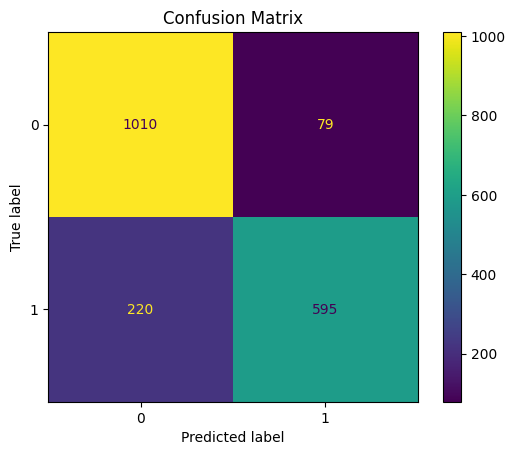

In [14]:
cm = sklearn.metrics.confusion_matrix(true, pred)
sklearn.metrics.ConfusionMatrixDisplay(cm).plot()
plt.title('Confusion Matrix')

confusion_matrix = plt.gcf()
confusion_matrix.savefig('results/confusion_matrix.svg')

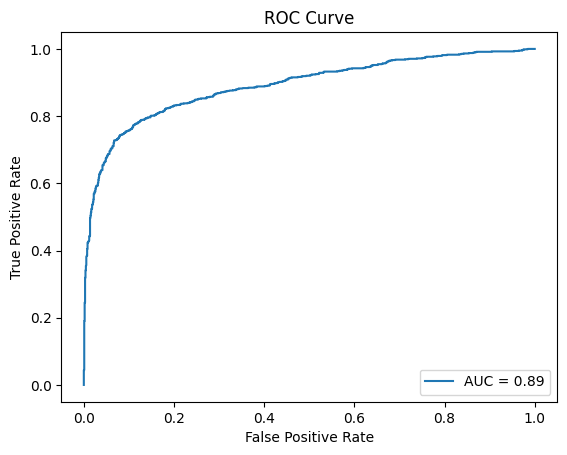

In [15]:
fpr, tpr, thresholds = sklearn.metrics.roc_curve(true, pred_probs)
roc_auc = sklearn.metrics.auc(fpr, tpr)
sklearn.metrics.RocCurveDisplay(fpr = fpr, tpr = tpr, roc_auc = roc_auc).plot()
plt.title('ROC Curve')

roc_curve = plt.gcf()
roc_curve.savefig('results/roc_curve.svg')

In [16]:
kaggle_eval = pd.read_csv('data/test.csv')[['id', 'keyword', 'location', 'text']].fillna('')
kaggle_eval.text = kaggle_eval.text.map(TweetNormalizer.normalizeTweet)

kaggle_eval.head()

,id,keyword,location,text
0,0,,,Just happened a terrible car crash
1,2,,,"Heard about #earthquake is different cities , ..."
2,3,,,"there is a forest fire at spot pond , geese ar..."
3,9,,,Apocalypse lighting . #Spokane #wildfires
4,11,,,Typhoon Soudelor kills 28 in China and Taiwan


In [17]:
kaggle_keywords = tokenizer(kaggle_eval.keyword.tolist(),
                            padding = 'max_length',
                            return_tensors = 'pt',
                            truncation = True,                           
                            max_length = keywords['input_ids'].shape[1])

kaggle_locations = tokenizer(kaggle_eval.location.tolist(),
                             padding = 'max_length',
                             return_tensors = 'pt',
                             truncation = True,
                             max_length = locations['input_ids'].shape[1])

kaggle_texts = tokenizer(kaggle_eval.text.tolist(),
                         padding = 'max_length',
                         return_tensors = 'pt',
                         truncation = True,                         
                         max_length = texts['input_ids'].shape[1])

kaggle_targets = torch.tensor([-1]*len(kaggle_eval))

In [18]:
kaggle_eval_dataloader = torch.utils.data.DataLoader(
    Dataset(kaggle_keywords, kaggle_locations, kaggle_texts, kaggle_targets, range(len(kaggle_eval))),
    batch_size = batch_size
)

In [19]:
pred_probs = []
true = []

for (X, y) in kaggle_eval_dataloader:
    X = {k: v.to(device) for k, v in X.items()}
    pred_probs.extend(model(X).detach().cpu().numpy())

pred_probs = np.array(pred_probs)
pred = pred_probs > 0.5
kaggle_eval['prediction'] = pred

In [20]:
with open('kaggle_submission.csv', 'w') as handle:
    handle.write('id,target\n')
    for i, row in kaggle_eval.iterrows():
        handle.write(str(row.id) + ',' + str(int(row.prediction)) + '\n')